# Persamaan Schr&ouml;dinger
tarikh:: 2022-10-15

## 0. Import

In [1]:
import numpy as np
from scipy import sparse, integrate
import matplotlib.pyplot as plt
from matplotlib import animation

%matplotlib inline

## 1. Nilai Awal

In [2]:
# Set x range
dx: float   = 0.02
x: np.array = np.arange(0, 10, dx)

# Wave properties
k_x: float  = 0.1                   # Wave number
m: float    = 1.0                   # Mass of wave

# Wave packet initialization
wave_w: float    = 0.1               # Width of initial gaussian wave packet
wave_x: float   = 3.0               # Center of initial gaussian wave packet

A: float        = 1.0 / (wave_w * np.sqrt(np.pi))    # Normalization constant

### 1.1 Fungsi Penting
Dua fungsi penting dalam pers. Schr&ouml;dinger ialah fungsi gelombang, $\psi(x)$ (yang bertakrif) dan fungsi keupayaan $V(x)$ (yang sembarangan):

$$\psi(x)=\sqrt{A}e^{-\frac{(x-x_0)^2}{2\text{width}^2}}e^{(ik_xx)}$$

<!-- TODO Baca tentang gaussian wave packet -->

Total Probability:  0.9999999999999992


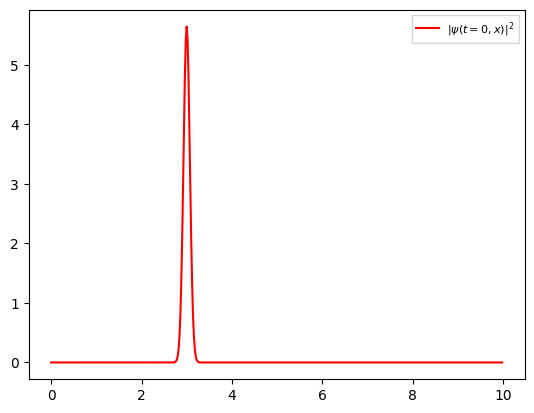

In [3]:
# Fungsi gelombang
psi_0: np.array    = np.exp(-(x-wave_x)**2 / (2.0 * wave_w**2)) * np.exp(1j * k_x * x) * np.sqrt(A)

plt.plot(x, np.abs(psi_0)**2, "r", label=r"$\vert\psi(t=0,x)\vert^2$")
plt.legend(loc=1, fontsize=8, fancybox=False)
print("Total Probability: ", np.sum(np.abs(psi_0)**2)*dx)

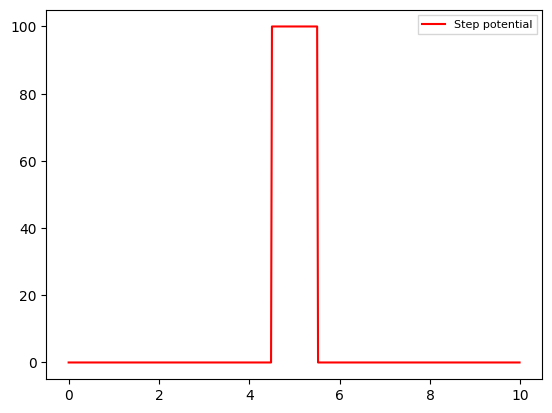

In [13]:
# Fungsi keupayaan V(x)
# Step potential
V_height = 100

V = np.zeros(x.shape)
for i, _x in enumerate(x):
    if _x >= 4.5 and _x <= 5.5:
        V[i] = V_height


plt.plot(x, V, "r", label=r"Step potential")
plt.legend(loc=1, fontsize=8, fancybox=False)

### 1.2 Laplace Operator (Finite Difference)

The 1-D Laplace operator $\nabla^2=\frac{\partial^2}{\partial x^2}$ can be expressed in terms of a banded matrix:

\begin{align}
\frac{\partial^2}{\partial x^2} y(x)
&= 
\frac{1}{dx} \left[ \frac{y_{n+1} - y_{n}}{dx} - \frac{y_{n} - y_{n-1}}{dx} \right]
\\
&=
\frac{y_{n+1} - 2 y_{n} + y_{n-1}}{(dx)^2} 
\\
&=
\frac{1}{(dx)^2}
\begin{pmatrix}
  -2  &  1  &  0  &  0 &  0 \\
   1  & -2  &  1  &  0 &  0 \\
   0  &  1  & -2  &  1 &  0 \\
   0  &  0  &  1  & -2 &  1 \\
   0  &  0  &  0  &  1 & -2 
\end{pmatrix}
\cdot
\begin{pmatrix}
   y_1   \\
   y_2   \\
   y_3   \\
   y_4   \\
   y_5  
\end{pmatrix}
\\
&\equiv
\mathbf{D2} \cdot \mathbf{y}
\end{align}

In [14]:
# Laplace Operator
D2: sparse.dia_matrix = sparse.diags([1,-2,1], [-1,0,1], shape=(x.size, x.size)) / dx**2
D2.toarray()*dx**2

array([[-2.,  1.,  0., ...,  0.,  0.,  0.],
       [ 1., -2.,  1., ...,  0.,  0.,  0.],
       [ 0.,  1., -2., ...,  0.,  0.,  0.],
       ...,
       [ 0.,  0.,  0., ..., -2.,  1.,  0.],
       [ 0.,  0.,  0., ...,  1., -2.,  1.],
       [ 0.,  0.,  0., ...,  0.,  1., -2.]])

Boleh cuba tengok sendiri kesahihan matrix `D2` dengan melihat samaada `D2 * sin(x)` akan hasilkan `-sin(x) = cos(x)` atau tak seperti yang dijangka.

## 2.0 Penyelesaian

Original 1-D Schrodinger equation: $-\frac{\hbar^2}{2m}\nabla^2\psi + V \psi = i\hbar\frac{\partial}{\partial t}\psi$


$$\therefore \psi_t \equiv \frac{\partial}{\partial t}\psi(t,x) = -i\left[-\frac{\hbar}{2m}\nabla^2\psi(t,x) + \frac{1}{\hbar} V(x) \psi(t,x)\right]$$

In [15]:
# Defining the Schrodinger wave function

hbar: float = 1.0

def psi_t(t: np.array, psi: np.array) -> np.array:
    return - 1j * ((-0.5 * hbar / m) * D2.dot(psi) + (V/hbar)*psi)


In [16]:
# We will use scipy to solve the equations

dt: float           = 0.005  # time interval for snapshots
t0: float           = 0.0    # initial time
tf: float           = 1.0    # final time
t_eval: np.array    = np.arange(t0, tf, dt)  # recorded time shots

# Solve the Initial Value Problem
sol = integrate.solve_ivp(psi_t, t_span = [t0, tf], y0 = psi_0, t_eval = t_eval, method="RK23")

## 3. Plotting &amp; Animation

### 3.1 Plotting

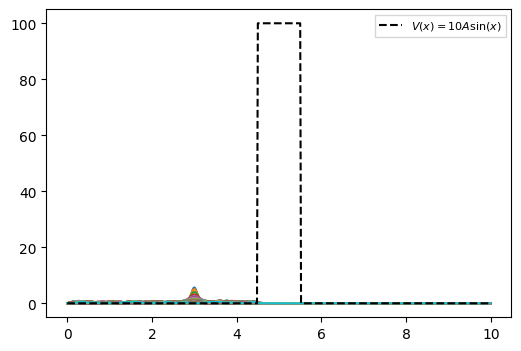

In [17]:
fig = plt.figure(figsize=(6, 4))
for i, t in enumerate(sol.t):
    plt.plot(x, np.abs(sol.y[:,i])**2)                  # Plot Wavefunctions
    # print(f'Total probability: {np.sum(np.abs(sol.y[:,i])**2)*dx}')           # Print Total Probability (Should = 1)
plt.plot(x, V, "k--", label=r"$V(x) = 10 A \sin(x)$")   # Plot Potential
plt.legend(loc=1, fontsize=8, fancybox=False)
fig.savefig('sho@2x.png')

### 3.2 Animation

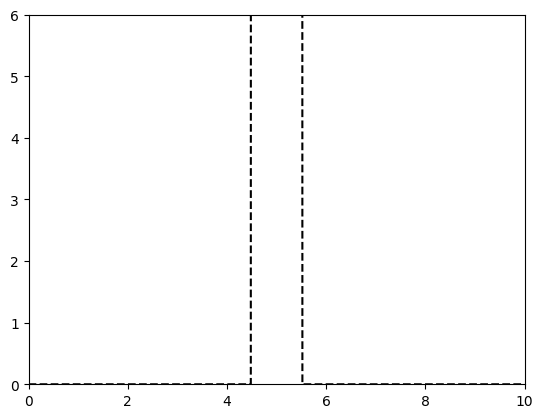

In [18]:
fig = plt.figure()
ax1 = plt.subplot(1,1,1)
ax1.set_xlim(0, 10)
ax1.set_ylim(0, 6)
title = ax1.set_title('')
line1, = ax1.plot([], [], "k--")
line2, = ax1.plot([], [])


def init():
    line1.set_data(x, V)
    return line1,


def animate(i):
    line2.set_data(x, np.abs(sol.y[:,i])**2)
    title.set_text('Time = {0:1.3f}'.format(sol.t[i]))
    return line1,


anim = animation.FuncAnimation(fig, animate, init_func=init,
                               frames=len(sol.t), interval=50, blit=True)

In [20]:
# Save the animation into a short video
anim.save('sho_v100.mp4', fps=15, extra_args=['-vcodec', 'libx264'], dpi=300)